# Data Exploration

## 🌐Cell 1: Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

current_dir = Path(os.getcwd())
BASE_DIR = current_dir.parent

if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"

sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False

# from src.preprocessing import clean_robot_data 

print(f"✅ EDA environment is ready,root set to:：{BASE_DIR}")

✅ EDA environment is ready,root set to:：l:\Foundations of Machine Learning Frameworks\LinearRegressionArchitecture_Workshop


## 🌐Cell 2: Read Data

In [6]:
# 🌐 Cell 2: Read Data & Robust Cleaning
file_path = DATA_RAW / "RMBR4-2_export_test.csv"

if file_path.exists():
    # 1. Read CSV
    df = pd.read_csv(file_path)
    
    # 2. Robust Time Conversion
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time').reset_index(drop=True)
    
    # Calculate elapsed seconds for regression
    df['Elapsed_Seconds'] = (df['Time'] - df['Time'].min()).dt.total_seconds()
    
    # 3. Handle Axis #1 to #8 (Data Cleaning)
    target_axes = [f"Axis #{i}" for i in range(1, 9)]
    for col in target_axes:
        # Convert to numeric, handle errors, and fill missing values with 0
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    print(f"✅ Data loaded and cleaned! Total {df.shape[0]} records.")
    display(df[['Time', 'Elapsed_Seconds'] + target_axes].head())
else:
    print(f"❌ File not found! Please check the path: {file_path}")

✅ Data loaded and cleaned! Total 39672 records.


,Time,Elapsed_Seconds,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,2022-10-17 12:18:23.660000+00:00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-17 12:18:25.472000+00:00,1.812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-17 12:18:27.348000+00:00,3.688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-17 12:18:29.222000+00:00,5.562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-17 12:18:31.117000+00:00,7.457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 🌐Cell 3:Information Check & Data Exploration

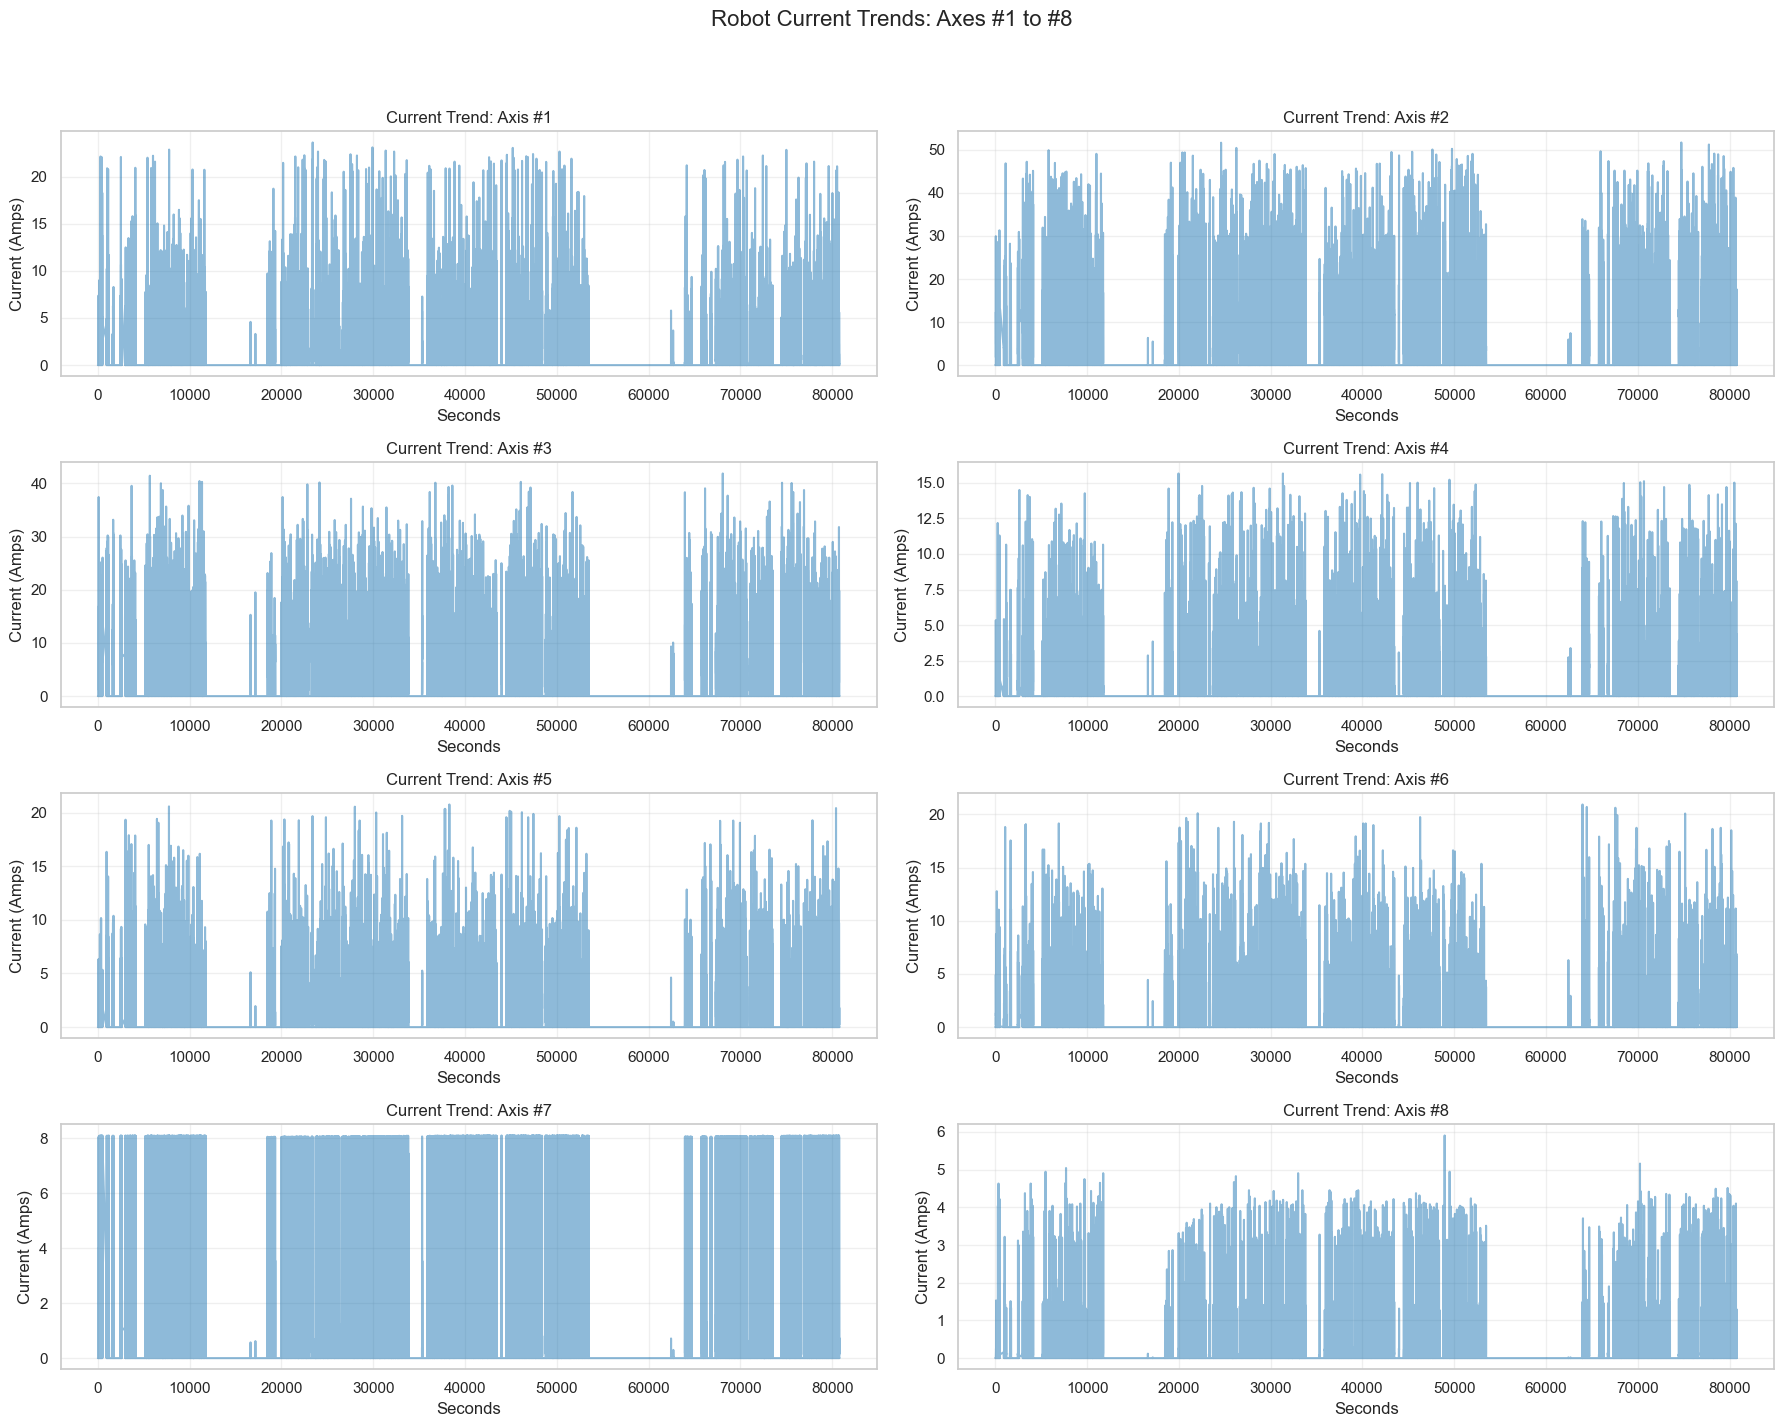

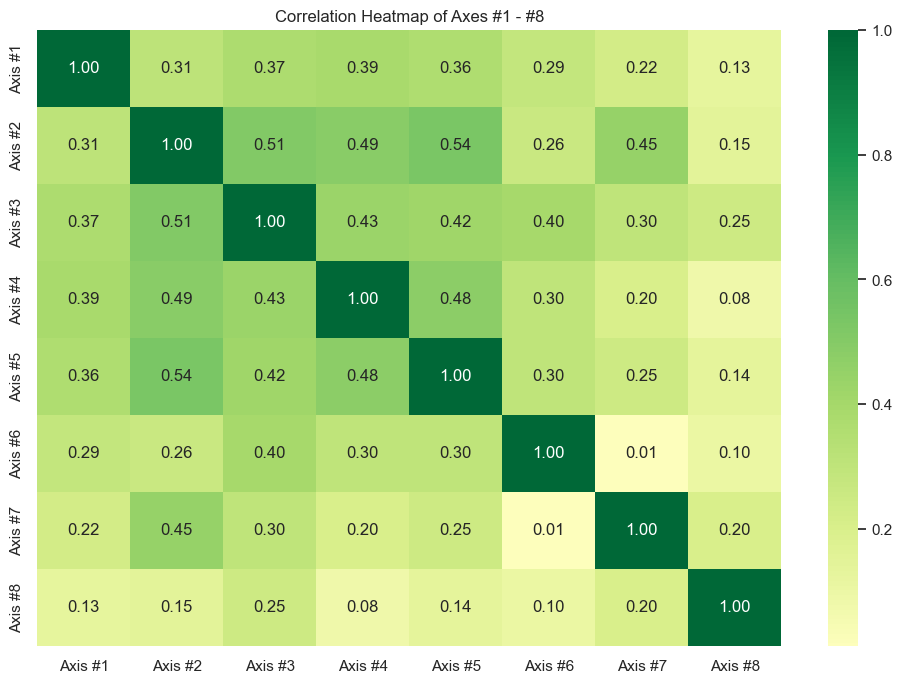

In [11]:
# 1. Plot all 8 axes in a single visualization grid
# This fulfills the "analyze patterns for each axis" requirement
fig, axes = plt.subplots(4, 2, figsize=(18, 15)) # 4 rows, 2 columns
fig.suptitle("Robot Current Trends: Axes #1 to #8", fontsize=16)

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

for i in range(1, 9):
    ax = axes_flat[i-1]
    col_name = f'Axis #{i}'
    
    # Plot original current data
    ax.plot(df['Elapsed_Seconds'], df[col_name], color='tab:blue', alpha=0.5)
    ax.set_title(f"Current Trend: {col_name}")
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Current (Amps)")
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 

# 2. Advanced Correlation Heatmap for all 8 required axes
plt.figure(figsize=(12, 8))
# Select only the 8 target axes for the correlation study
target_cols = [f'Axis #{i}' for i in range(1, 9)]
correlation_matrix = df[target_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f", center=0)
plt.title("Correlation Heatmap of Axes #1 - #8")
plt.show()

#

## 🌐Cell 4: Data Cleaning & Transformation

Handling Missing Values & Outliers, Feature Engineering, Normalization/Standardization

### Why Smooth the Data?

- Filter Noise: Sensor readings often contain random fluctuations due to electromagnetic interference or instantaneous load changes; smoothing filters out this non-authentic noise.

- Capture Long-term Trends: Linear regression benefits from focusing on long-term degradation patterns instead of short-term spikes.

- Prevent Overfitting: Smoothing avoids teaching the model to fit meaningless outliers, improving prediction stability.

### Principles of Smoothing

- Moving Average: Uses a sliding window to compute the mean of recent data points and reduces short-term variability.

- Calculation Method: Each smoothed point is the average of neighboring observations, producing a continuous, smoother curve.

- Window Size: Larger windows produce smoother curves but increase lag in responding to real changes. Choose the window size based on data frequency and domain knowledge.

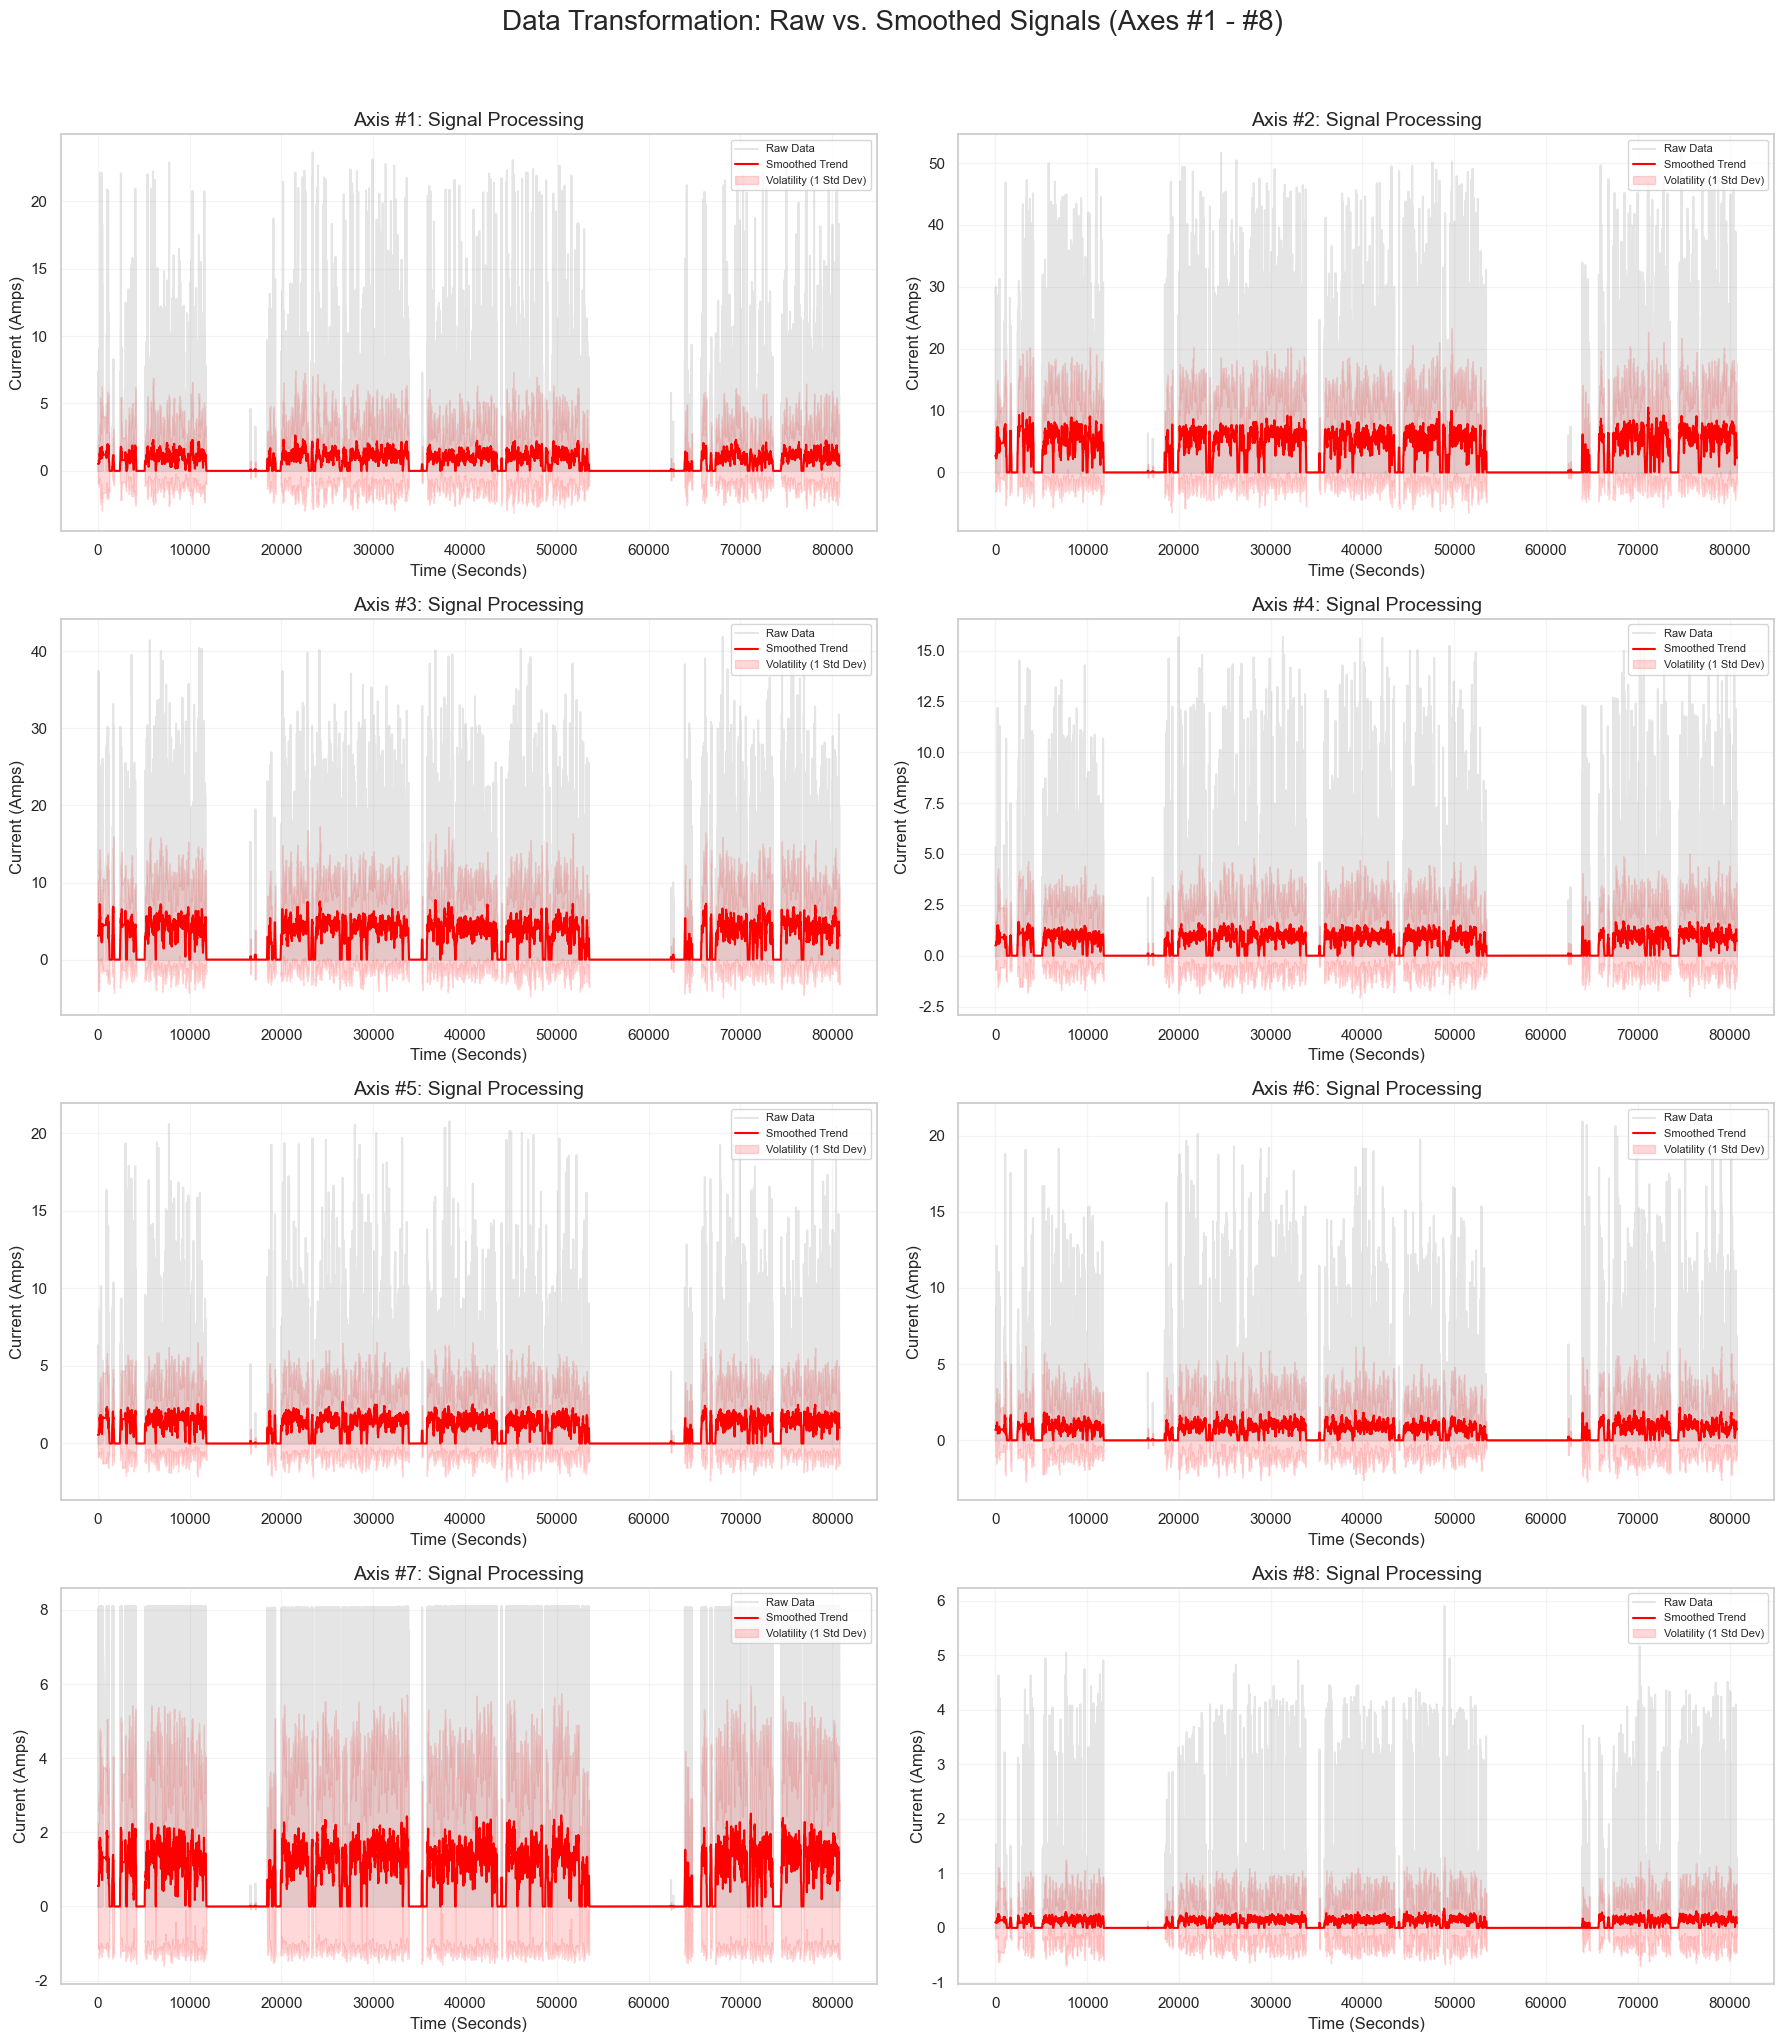

In [12]:
# 1. Define target axes (#1 to #8)
target_axes = [f"Axis #{i}" for i in range(1, 9)]
df_cleaned = df.dropna(axis=1, how='all').copy()

# 2. Batch Smoothing & Feature Engineering
window_size = 50
for axis_col in target_axes:
    base_name = axis_col.replace(" #", "").replace(" ", "")
    df_cleaned[f"{base_name}_Smooth"] = df_cleaned[axis_col].rolling(window=window_size, center=True).mean()
    df_cleaned[f"{base_name}_Std"] = df_cleaned[axis_col].rolling(window=window_size, center=True).std()

# 3. Handle NaNs
df_cleaned = df_cleaned.ffill().bfill()

# --- 5. Visualization: 8-Axis Raw vs Smoothed Comparison ---
# Create a grid of 4 rows and 2 columns to display all 8 axes
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
fig.suptitle("Data Transformation: Raw vs. Smoothed Signals (Axes #1 - #8)", fontsize=20, y=1.02)

axes_flat = axes.flatten()

for i in range(1, 9):
    ax = axes_flat[i-1]
    raw_col = f"Axis #{i}"
    smooth_col = f"Axis{i}_Smooth"
    std_col = f"Axis{i}_Std"
    
    # Plot Raw Data in background (Gray)
    ax.plot(df_cleaned['Elapsed_Seconds'], df_cleaned[raw_col], alpha=0.2, color='gray', label='Raw Data')
    
    # Plot Smoothed Trend (Red)
    ax.plot(df_cleaned['Elapsed_Seconds'], df_cleaned[smooth_col], color='red', linewidth=1.5, label='Smoothed Trend')
    
    # Visualize Volatility Band (Shaded Red Area)
    ax.fill_between(
        df_cleaned['Elapsed_Seconds'], 
        df_cleaned[smooth_col] - df_cleaned[std_col], 
        df_cleaned[smooth_col] + df_cleaned[std_col], 
        color='red', alpha=0.15, label='Volatility (1 Std Dev)'
    )
    
    ax.set_title(f"Axis #{i}: Signal Processing", fontsize=14)
    ax.set_xlabel("Time (Seconds)")
    ax.set_ylabel("Current (Amps)")
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### 🌐 Final Step: Feature Selection & Export

In [13]:
# Save the cleaned and processed data to a CSV file

# 1. Select only the necessary columns for the ML model: 
# Time index + Smoothed Trends + Volatility metrics
final_columns = ['Elapsed_Seconds'] + [c for c in df_cleaned.columns if 'Smooth' in c or 'Std' in c]

# 2. Define the output path in the processed data folder
processed_file_path = DATA_PROCESSED / "cleaned_data.csv"

# 3. Ensure the directory exists
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# 4. Save the optimized feature set
df_cleaned[final_columns].to_csv(processed_file_path, index=False)

print(f"✅ Multi-axis transformation complete.")
print(f"✅ Dataset with 8 axes saved to: {processed_file_path}")
print(f"📊 Total features exported: {len(final_columns)}")

# Final check: Display the first 5 rows of the exported data
display(df_cleaned[final_columns].head())

✅ Multi-axis transformation complete.
✅ Dataset with 8 axes saved to: l:\Foundations of Machine Learning Frameworks\LinearRegressionArchitecture_Workshop\data\processed\cleaned_data.csv
📊 Total features exported: 17


,Elapsed_Seconds,Axis1_Smooth,Axis1_Std,Axis2_Smooth,Axis2_Std,Axis3_Smooth,Axis3_Std,Axis4_Smooth,Axis4_Std,Axis5_Smooth,Axis5_Std,Axis6_Smooth,Axis6_Std,Axis7_Smooth,Axis7_Std,Axis8_Smooth,Axis8_Std
0,0.000,0.521698,1.450852,2.683184,5.758266,3.096468,7.172266,0.508445,1.203633,0.557484,1.414918,0.690144,1.794698,0.553046,1.695842,0.099277,0.283003
1,1.812,0.521698,1.450852,2.683184,5.758266,3.096468,7.172266,0.508445,1.203633,0.557484,1.414918,0.690144,1.794698,0.553046,1.695842,0.099277,0.283003
2,3.688,0.521698,1.450852,2.683184,5.758266,3.096468,7.172266,0.508445,1.203633,0.557484,1.414918,0.690144,1.794698,0.553046,1.695842,0.099277,0.283003
3,5.562,0.521698,1.450852,2.683184,5.758266,3.096468,7.172266,0.508445,1.203633,0.557484,1.414918,0.690144,1.794698,0.553046,1.695842,0.099277,0.283003
4,7.457,0.521698,1.450852,2.683184,5.758266,3.096468,7.172266,0.508445,1.203633,0.557484,1.414918,0.690144,1.794698,0.553046,1.695842,0.099277,0.283003
